In [277]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Analysis of  health insurance data

**В этом ноутбуке предложина методика расчета суммы выплат по договору на следующий страховой период (2023 год) на основе исторических данных за текущий период (2022 год) и информации о застрахованных на 2023 г**

**Данная работа состоит из трех этапов: 1 - работа с таблицей insured, 2 - работа с таблицей claims_22, 3 - составление прогноза. В комментариях описана логика действий и идеи, которых я придерживалась, также будут описаны по ходу работы.**

In [631]:
insured = pd.read_excel('/Users/anastasiaborisova/Desktop/mains/testing_exercise_future_claims_prediction.xlsx', sheet_name='Insured')
insured

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,EffectiveDate,CancellationDate
0,2405867,13877014-2022,2405838,Network-3,D,Saudi,Spouse,Female,1976-11-14,2022-01-01,2023-01-01
1,2405868,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,1996-05-30,2022-01-01,2023-01-01
2,2405886,13877014-2022,2405838,Network-3,D,Saudi,Child,Female,2016-01-18,2022-01-01,2023-01-01
3,2405887,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,2018-08-31,2022-01-01,2023-01-01
4,2405900,13877014-2022,2405838,Network-3,D,Saudi,Self,Male,1993-08-27,2022-01-01,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
4099,89334449,13915889-2022,67851323,Network-5,C,Group 2,Self,Male,1983-03-10,2022-02-01,2023-02-01
4100,89334464,15283773-2023,67851323,Network-5,C,Group 2,Self,Male,1993-10-15,2023-02-01,2024-02-01
4101,90751920,13876404-2022,421041,Network-5,D,Group 2,Self,Male,1991-10-07,2022-01-01,2022-11-09
4102,9357173,14944144-2023,2359244,Network-1,B,Group 2,Self,Male,1977-12-31,2023-01-01,2024-01-01


In [632]:
#Создадим колонку с продолжительностью действия страхового полиса
insured['policy duration'] = (insured['CancellationDate'] - insured['EffectiveDate']).dt.days
insured


,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,EffectiveDate,CancellationDate,policy duration
0,2405867,13877014-2022,2405838,Network-3,D,Saudi,Spouse,Female,1976-11-14,2022-01-01,2023-01-01,365
1,2405868,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,1996-05-30,2022-01-01,2023-01-01,365
2,2405886,13877014-2022,2405838,Network-3,D,Saudi,Child,Female,2016-01-18,2022-01-01,2023-01-01,365
3,2405887,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,2018-08-31,2022-01-01,2023-01-01,365
4,2405900,13877014-2022,2405838,Network-3,D,Saudi,Self,Male,1993-08-27,2022-01-01,2023-01-01,365
...,...,...,...,...,...,...,...,...,...,...,...,...
4099,89334449,13915889-2022,67851323,Network-5,C,Group 2,Self,Male,1983-03-10,2022-02-01,2023-02-01,365
4100,89334464,15283773-2023,67851323,Network-5,C,Group 2,Self,Male,1993-10-15,2023-02-01,2024-02-01,365
4101,90751920,13876404-2022,421041,Network-5,D,Group 2,Self,Male,1991-10-07,2022-01-01,2022-11-09,312
4102,9357173,14944144-2023,2359244,Network-1,B,Group 2,Self,Male,1977-12-31,2023-01-01,2024-01-01,365


In [264]:
insured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4104 entries, 0 to 4103
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   MemberID          4104 non-null   int64         
 1   PolicyID          4104 non-null   object        
 2   ClientID          4104 non-null   int64         
 3   MemberNetwork     4104 non-null   object        
 4   Class             4104 non-null   object        
 5   Nationality       4104 non-null   object        
 6   Relation          4104 non-null   object        
 7   Gender            4104 non-null   object        
 8   DateOfBirth       4104 non-null   datetime64[ns]
 9   EffectiveDate     4104 non-null   datetime64[ns]
 10  CancellationDate  4104 non-null   datetime64[ns]
 11  policy duration   4104 non-null   int64         
dtypes: datetime64[ns](3), int64(3), object(6)
memory usage: 384.9+ KB


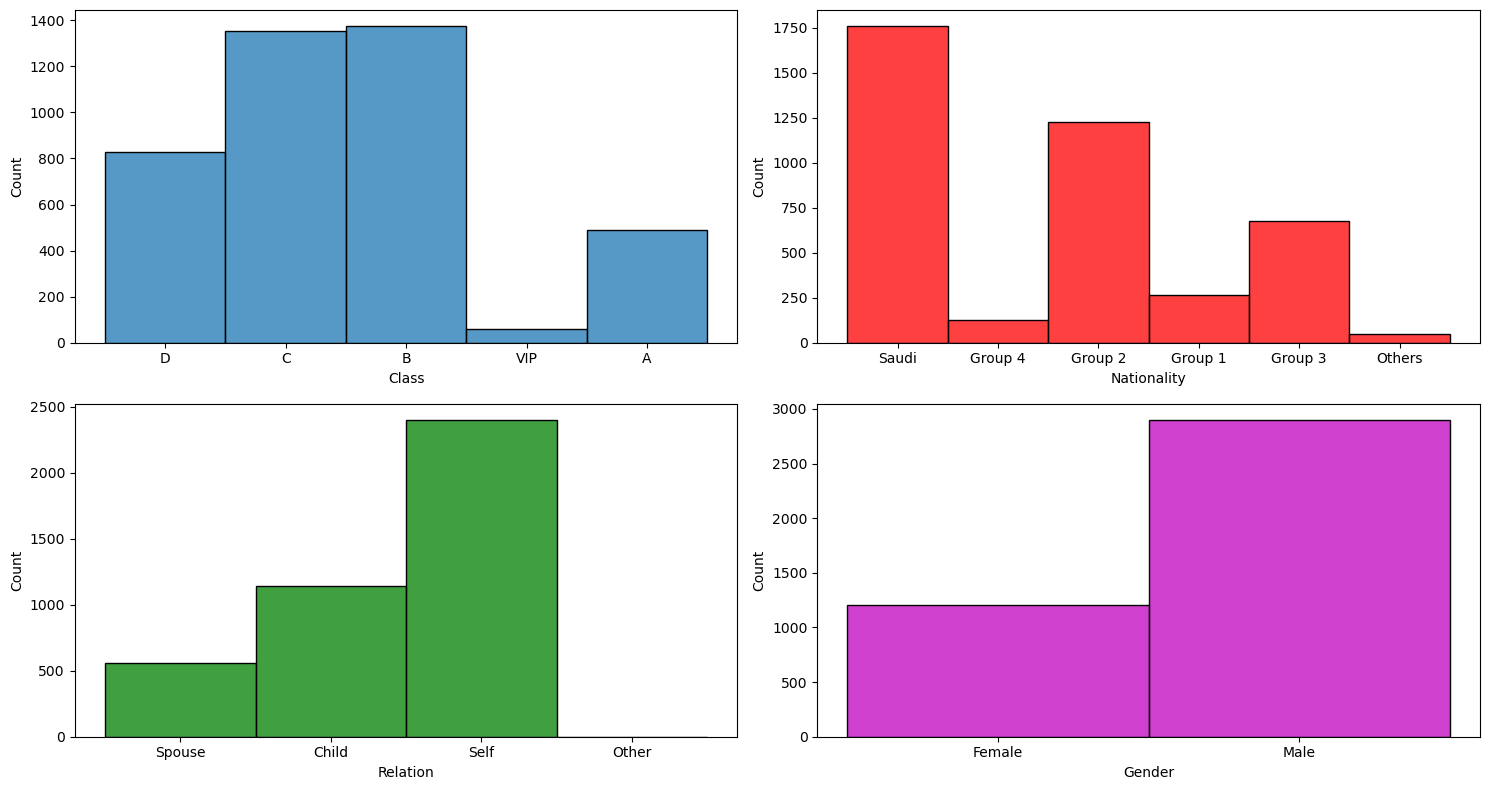

In [263]:
#Посмотрим гистограммы по некоторым колонкам

fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (15, 8))

sns.histplot(insured['Class'], ax=axs[0][0])
sns.histplot(insured['Nationality'], color = 'r', ax=axs[0][1])
sns.histplot(insured['Relation'], color = 'g', ax=axs[1][0])
sns.histplot(insured['Gender'], color = 'm', ax=axs[1][1])

plt.tight_layout()

In [633]:
#Введем колонку Age, где будет выделено три категории: 0-18 лет, 18-65, 65+

insured['Age'] = insured['DateOfBirth'].apply(lambda birth_date: relativedelta(datetime.now(), birth_date).years)

def categorize_age(age):
    if age < 18:
        return '0-17'
    elif 18 <= age < 65:
        return '18-65'
    else:
        return '65+'

insured['Age category'] = insured['Age'].apply(categorize_age)

insured

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,EffectiveDate,CancellationDate,policy duration,Age,Age category
0,2405867,13877014-2022,2405838,Network-3,D,Saudi,Spouse,Female,1976-11-14,2022-01-01,2023-01-01,365,47,18-65
1,2405868,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,1996-05-30,2022-01-01,2023-01-01,365,28,18-65
2,2405886,13877014-2022,2405838,Network-3,D,Saudi,Child,Female,2016-01-18,2022-01-01,2023-01-01,365,8,0-17
3,2405887,13877014-2022,2405838,Network-3,D,Saudi,Child,Male,2018-08-31,2022-01-01,2023-01-01,365,6,0-17
4,2405900,13877014-2022,2405838,Network-3,D,Saudi,Self,Male,1993-08-27,2022-01-01,2023-01-01,365,31,18-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,89334449,13915889-2022,67851323,Network-5,C,Group 2,Self,Male,1983-03-10,2022-02-01,2023-02-01,365,41,18-65
4100,89334464,15283773-2023,67851323,Network-5,C,Group 2,Self,Male,1993-10-15,2023-02-01,2024-02-01,365,30,18-65
4101,90751920,13876404-2022,421041,Network-5,D,Group 2,Self,Male,1991-10-07,2022-01-01,2022-11-09,312,32,18-65
4102,9357173,14944144-2023,2359244,Network-1,B,Group 2,Self,Male,1977-12-31,2023-01-01,2024-01-01,365,46,18-65


In [282]:
# Есть люди, у которых прерывался полис - могут быть как с полисами за 22 и 23, так и только за 1 год 

insured['MemberID'].value_counts()

MemberID
53467779    3
7496080     3
75829683    3
79004648    3
4199209     3
           ..
70016286    1
70016302    1
721297      1
738065      1
90751920    1
Name: count, Length: 2370, dtype: int64

In [634]:
# выведем тех MemberID, у которых прерывалось действие полиса и есть полис в 22 и 23 году

three_polices = insured['MemberID'].value_counts().index[(insured['MemberID'].value_counts() == 3)]
three_polices_id = insured[(insured['MemberID'].isin(three_polices))]
three_polices_id


,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,EffectiveDate,CancellationDate,policy duration,Age,Age category
30,3159917,14945331-2023,2405838,Network-3,C,Saudi,Self,Female,1985-03-06,2023-01-01,2023-03-04,62,39,18-65
31,3159917,14945331-2023,2405838,Network-3,C,Saudi,Self,Female,1985-03-06,2023-03-05,2024-01-01,302,39,18-65
32,3290143,13877014-2022,2405838,Network-3,D,Saudi,Self,Female,1973-07-30,2022-01-01,2023-01-01,365,51,18-65
33,3291940,13877014-2022,2405838,Network-3,D,Saudi,Spouse,Female,1996-12-03,2022-01-01,2023-01-01,365,27,18-65
38,3672725,14945331-2023,2405838,Network-3,C,Saudi,Child,Male,2021-10-26,2023-01-01,2023-01-23,22,2,0-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058,80343084,13876404-2022,421041,Network-2,C,Group 2,Self,Male,1968-06-29,2022-08-30,2023-01-01,124,56,18-65
4082,84541766,13876396-2022,2359246,Network-1,B,Saudi,Spouse,Female,1995-10-16,2022-03-23,2023-01-01,284,28,18-65
4083,84541766,13876404-2022,421041,Network-1,B,Saudi,Spouse,Female,1995-10-16,2022-01-01,2022-03-22,80,28,18-65
4085,84839632,14944144-2023,2359244,Network-2,C,Saudi,Child,Female,1993-10-28,2023-01-01,2024-01-01,365,30,18-65


In [635]:
# У этих людей менялась компания, которая их страховала. 
#Но есть люди, у которых причина разрыва полиса - смена ClientID

three_polices_id = three_polices_id[['MemberID', 'ClientID']].drop_duplicates()

three_polices_id['MemberID'].value_counts()

MemberID
3612563     2
1707831     2
84839640    2
79004820    2
84541766    2
           ..
2787450     1
2763950     1
2291572     1
1983177     1
90751904    1
Name: count, Length: 79, dtype: int64

In [636]:
#Таких людей 9 (у которых причина разрыва полиса - смена ClientID), удалим их

three_polices_index = three_polices_id['MemberID'].value_counts().index[(three_polices_id['MemberID'].value_counts() == 2)]
insured = insured[~insured['MemberID'].isin(three_polices_index)]


In [638]:
#Есть случаи, где у человека 2 записи в insured - разрыв полиса произошел из-за смены ClientID
#Также почистим

two_polices = insured['MemberID'].value_counts().index[(insured['MemberID'].value_counts() == 2)]
two_polices_id = insured[(insured['MemberID'].isin(two_polices))] 

two_polices_id = two_polices_id[['MemberID', 'ClientID']].drop_duplicates()

two_polices_index = two_polices_id['MemberID'].value_counts().index[(two_polices_id['MemberID'].value_counts() == 2)]
insured = insured[~insured['MemberID'].isin(two_polices_index)]

insured['MemberID'].value_counts()

MemberID
2653896     3
90751904    3
4195757     3
2099248     3
708790      3
           ..
70016286    1
70016302    1
721297      1
738065      1
90751920    1
Name: count, Length: 2353, dtype: int64

In [639]:
#Есть такие кейсы, у которых произошел разрыв полиса. Ниже описана функция aggregate_rows, которая это делает
insured[insured['MemberID'] == 2653896]

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,EffectiveDate,CancellationDate,policy duration,Age,Age category
1288,2653896,13876396-2022,2359246,Network-1,A,Saudi,Self,Male,1974-01-20,2022-03-23,2023-01-01,284,50,18-65
1551,2653896,13876396-2022,2359246,Network-1,A,Saudi,Self,Male,1974-01-20,2022-01-01,2022-03-15,73,50,18-65
3290,2653896,13876396-2022,2359246,Network-1,A,Saudi,Self,Male,1974-01-20,2022-03-16,2022-03-22,6,50,18-65


In [642]:
insured_new = insured.copy()

grouped_m = insured_new.groupby(['MemberID', 'PolicyID', 'ClientID', 'MemberNetwork', 'Class',
       'Nationality', 'Relation', 'Gender', 'DateOfBirth', 'Age', 'Age category'])

def aggregate_rows(group):
    start_date = group['EffectiveDate'].min()
    end_date = group['CancellationDate'].max()
    total_value = group['policy duration'].sum()
    return pd.Series({
        'EffectiveDate': start_date,
        'CancellationDate': end_date,
        'policy duration': total_value
    })

insured_new = grouped_m.apply(aggregate_rows).reset_index()
insured_new

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,Age,Age category,EffectiveDate,CancellationDate,policy duration
0,61664,13876396-2022,2359246,Network-2,C,Group 2,Self,Male,1969-01-01,55,18-65,2022-01-01,2023-01-01,365
1,61664,14943955-2023,2359246,Network-2,C,Group 2,Self,Male,1969-01-01,55,18-65,2023-01-01,2024-01-01,365
2,61717,13876396-2022,2359246,Network-5,D,Group 1,Self,Male,1971-01-01,53,18-65,2022-01-01,2023-01-01,365
3,61717,14943955-2023,2359246,Network-4,D,Group 1,Self,Male,1971-01-01,53,18-65,2023-01-01,2024-01-01,365
4,61975,13876396-2022,2359246,Network-5,D,Group 2,Self,Male,1965-01-01,59,18-65,2022-01-01,2023-01-01,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959,90751987,14944110-2023,421041,Network-2,C,Group 2,Self,Male,1984-05-18,40,18-65,2023-01-01,2024-01-01,365
3960,90751995,13876404-2022,421041,Network-5,D,Group 2,Self,Male,1984-11-20,39,18-65,2022-01-01,2023-01-01,365
3961,90751995,14944110-2023,421041,Network-4,D,Group 2,Self,Male,1984-11-20,39,18-65,2023-01-01,2024-01-01,365
3962,90752068,13876511-2022,2359244,Network-2,C,Group 2,Self,Male,1983-09-23,40,18-65,2022-01-01,2023-01-01,365


In [643]:
#Результат действия функции
insured_new[insured_new['MemberID'] == 42064679]

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,Age,Age category,EffectiveDate,CancellationDate,policy duration
2504,42064679,13876396-2022,2359246,Network-5,D,Group 1,Self,Male,1969-01-01,55,18-65,2022-01-01,2023-01-01,365
2505,42064679,14943955-2023,2359246,Network-4,D,Group 1,Self,Male,1969-01-01,55,18-65,2023-01-01,2024-01-01,365


In [644]:
#Теперь делаем выборку для 22 года и для 23 года

insured_22 = insured_new[insured_new['PolicyID'].str.contains('2022')]
insured_23 = insured_new[insured_new['PolicyID'].str.contains('2023')]
insured_23[insured_23['MemberID'] == 4779661]

,MemberID,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,DateOfBirth,Age,Age category,EffectiveDate,CancellationDate,policy duration
1934,4779661,14945331-2023,2405838,Network-8,D,Saudi,Child,Male,2022-02-26,2,0-17,2023-01-01,2024-01-01,365
1935,4779661,14945331-2023,2405838,Network-8,VIP,Saudi,Child,Male,2022-02-26,2,0-17,2023-01-01,2024-01-01,365


In [484]:
insured_22['ClientID'].value_counts()

ClientID
67851323    529
2359244     520
421041      383
2405838     352
2359246     334
Name: count, dtype: int64

In [483]:
insured_23['ClientID'].value_counts()

ClientID
67851323    582
421041      361
2405838     350
2359246     308
2359244     245
Name: count, dtype: int64

# Выгрузка таблицы claims_22

In [613]:
claims_22 = pd.read_excel('/Users/anastasiaborisova/Desktop/mains/testing_exercise_future_claims_prediction.xlsx', sheet_name='Claims 2022')
claims_22

,ClaimID,MemberID,PolicyID,ProviderID,ProviderType,Diagnosis,SecondaryDiagnoses,OccurrenceDate,Benefit,GrossAmount,ServiceName,ServiceCategory
0,202200740556,77735110,13877014-2022,25000534,Hospital,T14.2,T14.2,2022-01-03,Out-Patient,30.00,Specialist Consultation,Professional Fees
1,202200458181,61182204,13877014-2022,11800467,Complex,E11,NaN,2022-01-04,Out-Patient,11.15,DOLVIC- K 50 MG F- C TABLETS,Portal Medicine/Drug
2,202200458181,61182204,13877014-2022,11800467,Complex,E11,NaN,2022-01-04,Out-Patient,71.30,GLADOS 30MG TABLET,Portal Medicine/Drug
3,202201005642,61182337,13877014-2022,26080915,Day Surgery,H05.2,H05.2,2022-01-04,Out-Patient,100.00,Specialist Consultation,Professional Fees
4,202200458181,61182204,13877014-2022,11800467,Complex,E11,NaN,2022-01-04,Out-Patient,11.75,RUMAFEN,Portal Medicine/Drug
...,...,...,...,...,...,...,...,...,...,...,...,...
47694,202300817210,56636313,13915889-2022,12253,Complex,K80.80,R10.4;K80.80,2023-01-31,Out-Patient,75.25,C.B.C.,Portal Laboratory
47695,202303326457,3746994,13915889-2022,339010,Complex,S50.0,S50.0,2023-01-31,Out-Patient,9.00,Other Services (NEC),Other Services
47696,202303326457,3746994,13915889-2022,339010,Complex,S50.0,S50.0,2023-01-31,Out-Patient,160.00,X-Rays,X-Ray
47697,202303326457,3746994,13915889-2022,339010,Complex,S50.0,S50.0,2023-01-31,Out-Patient,25.00,Specialist Consultation,Professional Fees


**В ProviderType есть такие категории как Day Surgery, Ambulance Services, Radiography и на мой взгляд это сложно прогнозировать в силу того, что кейсы из этих категорий единичны. Категорию Hearing я также решила удалить, так как в ней были кейсы, связанные с потерей слуха(так понимаю лечение и установка аппарата). Такая процедура также кажется единичной и эти категории не будут рассматриваться в моем прогнозе.** 

In [616]:
claims_22['ProviderType'].value_counts()

ProviderType
Hospital         24886
Complex          20890
Pharmacy           829
Optics             552
Dental             389
Physiotherapy       65
Name: count, dtype: int64

In [615]:
claims_22 = claims_22[~claims_22['ProviderType'].str.contains('Radiography')]
claims_22 = claims_22[~claims_22['ProviderType'].str.contains('Hearing')]
claims_22 = claims_22[~claims_22['ProviderType'].str.contains('Ambulance Services')]
claims_22 = claims_22[~claims_22['ProviderType'].str.contains('Day Surgery')]

In [619]:
claims_22['Benefit'].value_counts()

Benefit
Out-Patient     39617
Maternity        2761
In-Patient       2268
Dental Care      1996
Optical Care      544
Name: count, dtype: int64

**Далее я прошлась по каждому бенефиту и посмотрела диапазон GrossAmount для каждого**

In [618]:
claims_22 = claims_22[claims_22['GrossAmount'] > 0]

In [518]:
#Рассматриваем бенефит Out-Patient
out_pat =  claims_22[(claims_22['Benefit'] == 'Out-Patient')]

In [519]:
expensive = out_pat[out_pat['GrossAmount'] > 500]
expensive['ServiceName'].value_counts()

ServiceName
Medication                                                                                                                                204
Laboratory Investigations                                                                                                                 139
Not Elsewhere Classified Item                                                                                                              23
Other Services (NEC)                                                                                                                       16
VITAMIN D (25-HYDROXYCHOLICALCIFEROL)                                                                                                      14
                                                                                                                                         ... 
XIFAXAN 200MG F.C.TABLET                                                                                                                

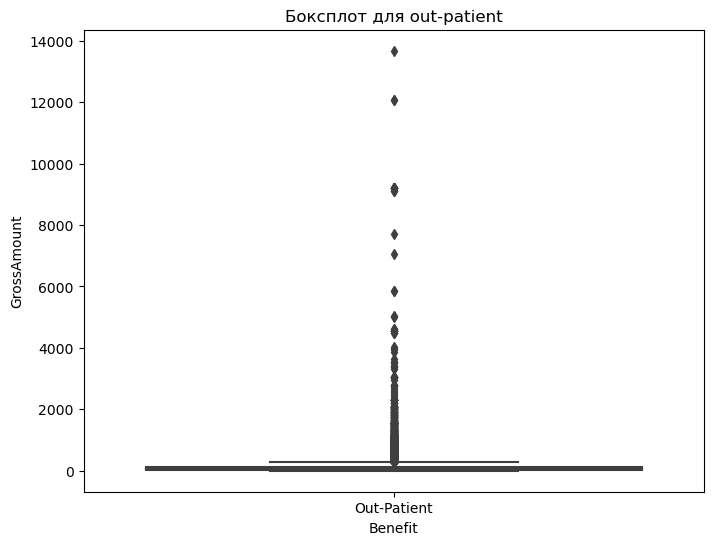

In [520]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Benefit', y='GrossAmount', data=out_pat)

plt.title('Боксплот для out-patient')
plt.show()


**Посмотрев "аномальные" значения ServiceName для Out-patient я пришла к выводу, что убирать мы их не можем, так как преимущественно это лекарства, доп.исследования и их назначение может повториться. Однако это завысит прогноз, если делать его средним. Возможно стоит попробовать прогнозировать медианой**

**С ведением беременности все неоднозначно. Есть несколько случаев
1)Женщина еще не родила и ведет беременность -> родит в следующем году и будет дорогостоящая услуга
2)Женщина вела беременность, родила -> непрогнозируемая ситуация далее т.к рождение в 22 году не исключает рождение в 23**

In [506]:
maternity = claims_22[(claims_22['Benefit'] == 'Maternity')]
maternity['ServiceName'].value_counts()


ServiceName
Not Elsewhere Classified Item    173
Specialist Consultation           60
Medication                        58
SPECIALIST FEE                    48
OSTEOCARE                         44
                                ... 
RBS Random Blood Sugar             1
Normal Delivery                    1
AVOCIN                             1
EASY MAX BGM VOICE DVC 1'S         1
NUTRI - NATAL                      1
Name: count, Length: 769, dtype: int64

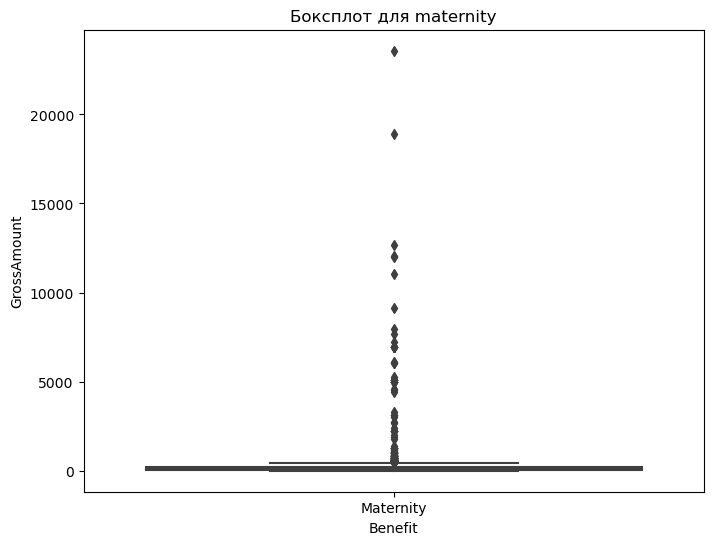

In [498]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Benefit', y='GrossAmount', data=maternity)

plt.title('Боксплот для maternity')
plt.show()

**Ниже я почистила те кейсы, которые относятся к процессу рождения ребенка. Не факт, что эти услуги повторятся в следующем году у этих MemberID -> в прогнозе их не рассматриваем. Как вариант можно будет ввести коэффициент рождаемости и по нему пытаться пересчитать долю родивших женщин, что улучшит прогноз**

In [620]:
claims_22 = claims_22[
    ~(
        (claims_22['ServiceName'].str.contains('cesarian', case=False) | 
         claims_22['ServiceName'].str.contains('delivery', case=False) | 
         claims_22['ServiceName'].str.contains('caesarian', case=False) | 
         claims_22['ServiceName'].str.contains('DELIVERY', case=False)
        ) & 
        (claims_22['Benefit'] == 'Maternity')
    )
]

**In-Patient - видимо связано с госпитализацией, нахождением в больнице. Чистим кейсы, где услуги дороже 20000 - кажется это одноразовые случаи (смотрела по ServiceName) . По хорошему наверное круто было бы иметь разметку с одноразовыми кейсами, 
но я почистила парочку - аппендицит и катаракту как пример.**

In [591]:
in_pat = claims_22[claims_22['Benefit'] == 'In-Patient']

In [621]:
claims_22 = claims_22[~((claims_22['Benefit'] == 'In-Patient') & (claims_22['GrossAmount'] > 20000))] 
claims_22 = claims_22[~((claims_22['Benefit'] == 'In-Patient') & 
                        (claims_22['ServiceName'].str.contains('append', case=False)))]
claims_22 = claims_22[~((claims_22['Benefit'] == 'In-Patient') & 
                        (claims_22['ServiceName'].str.contains('CATARACT', case=False)))]

In [548]:
in_pat[in_pat['GrossAmount'] > 20000]

,ClaimID,MemberID,PolicyID,ProviderID,ProviderType,Diagnosis,SecondaryDiagnoses,OccurrenceDate,Benefit,GrossAmount,ServiceName,ServiceCategory
10390,202201242631,3437638,13915889-2022,13715614,Hospital,E66.9,E66.9,2022-03-28,In-Patient,22660.0,Package Deals (Legacy Claims),Package Deals
13932,202202302206,42065528,13876511-2022,78644543,Hospital,R07.4,I10;R07.4,2022-05-11,In-Patient,85500.0,PTCA - Double Vessels + 2 Stents DES,Portal Package Deals
22426,202202988388,37162736,13915889-2022,12146,Hospital,N20.1,N20.1;Y83.9,2022-07-19,In-Patient,23000.0,URETEROSCOPY COMPLEX,Portal Surgical Operations
44685,202205002101,42078711,13876404-2022,25950159,Hospital,M25.5,M25.5,2022-12-20,In-Patient,21168.0,ROTATOR CUFF REPAIR -1 DAY PKG.,Portal Package Deals


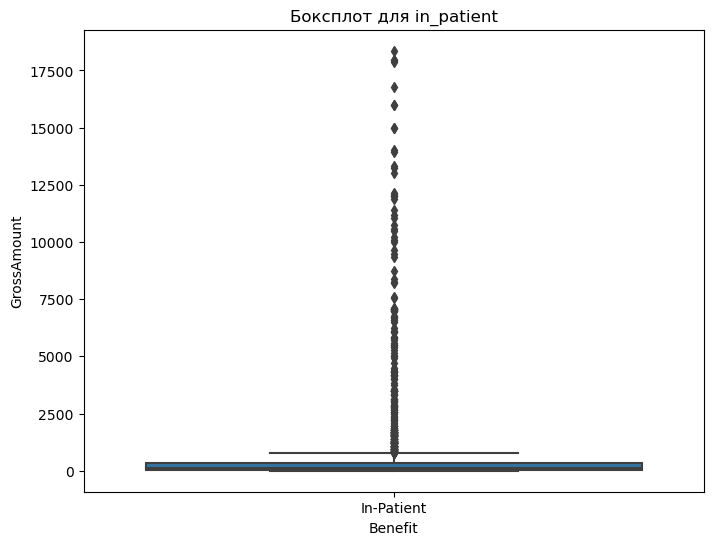

In [560]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Benefit', y='GrossAmount', data=in_pat)

plt.title('Боксплот для in_patient')
plt.show()

**Бенефит Dental было сложно почистить, но видно, что дорогие кейсы относятся, например, к удалению зуба мудрости - может повториться - также нужна разметка. Удалила самый дорогой кейс т.к. это удаление желез - не повторится**

In [607]:
dental = claims_22[(claims_22['Benefit'] == 'Dental Care')]
dental['ServiceName'].value_counts().iloc[:30]



ServiceName
Medication                                                            127
DENTAL CONSULTATION                                                   115
PANAROMIC X-RAY                                                        86
COMPOUND AMALGAM FILLING                                               77
Not Elsewhere Classified Item                                          57
Composite Filling (anterior + posterior)                               53
Dental panorama                                                        42
GENERAL  DENTISTRY - INTRAORAL X-RAY                                   34
COMPOSITE FILLING (ANTERIOR/POSTERIOR)                                 33
GINGIVAL TREATMENT                                                     33
KLAVOX 1GM TAB                                                         29
SURGICAL DENTAL EXTRACTION                                             27
DENTAL SCALING                                                         27
Consultation              

In [603]:
#Почистим одноразовый кейс, который связан с удалением слюнной железы
dental[dental['GrossAmount'] > 3000]
dental[dental['ServiceName'].str.contains('GLAND')]

,ClaimID,MemberID,PolicyID,ProviderID,ProviderType,Diagnosis,SecondaryDiagnoses,OccurrenceDate,Benefit,GrossAmount,ServiceName,ServiceCategory
21888,202202671098,16140489,13915889-2022,42740278,Complex,K02,K11.6,2022-07-14,Dental Care,6090.0,EXCISION OF MINOR SAIVARY GLAND (MUCOCELE),Portal Surgical Operations


In [622]:
#Почистим этот кейс
claims_22 = claims_22[~((claims_22['Benefit'] == 'Dental Care') & (claims_22['GrossAmount'] > 6000))]

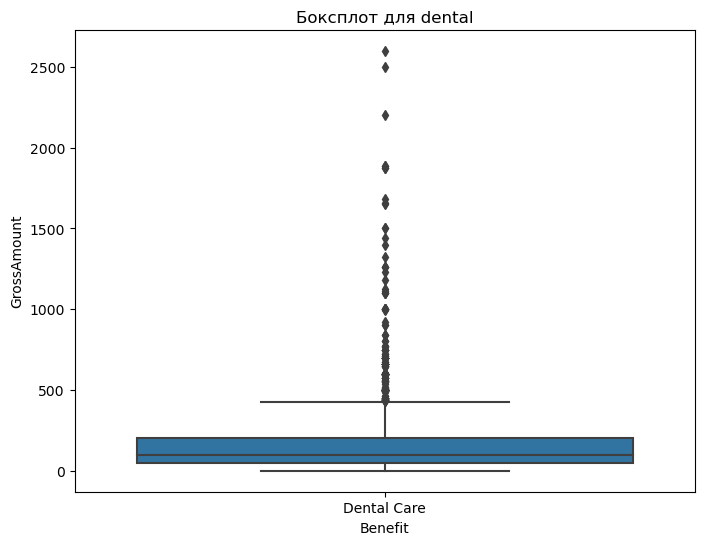

In [606]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Benefit', y='GrossAmount', data=dental)
plt.title('Боксплот для dental')
plt.show()


**В optical не вижу необходимости чистить данные, так как дорогостоящие услуги - линзы/очки(может повториться)**

In [611]:
optical = claims_22[(claims_22['Benefit'] == 'Optical Care') & (claims_22['GrossAmount'] > 650)]
optical


,ClaimID,MemberID,PolicyID,ProviderID,ProviderType,Diagnosis,SecondaryDiagnoses,OccurrenceDate,Benefit,GrossAmount,ServiceName,ServiceCategory
8398,202200906664,1603739,13876404-2022,1562332,Optics,H53,H53,2022-03-05,Optical Care,660.0,LENSES / EYE GLASSES,Optical
11206,202201405348,20558411,13876511-2022,3281868,Optics,H53,H53,2022-04-06,Optical Care,750.0,LENSES / EYE GLASSES,Optical
19986,202202451650,66554258,13876404-2022,12178,Optics,H53,H53,2022-06-25,Optical Care,750.0,LENSES / EYE GLASSES,Optical
19988,202202451910,83586549,13876404-2022,12178,Optics,H53,H53,2022-06-25,Optical Care,750.0,LENSES / EYE GLASSES,Optical
28426,202203514408,83894547,13915889-2022,12178,Optics,H53,H53,2022-09-10,Optical Care,700.0,LENSES / EYE GLASSES,Optical
34108,202204041518,81329843,13915889-2022,85699159,Optics,H53,H53,2022-10-16,Optical Care,800.0,LENSES / EYE GLASSES,Optical


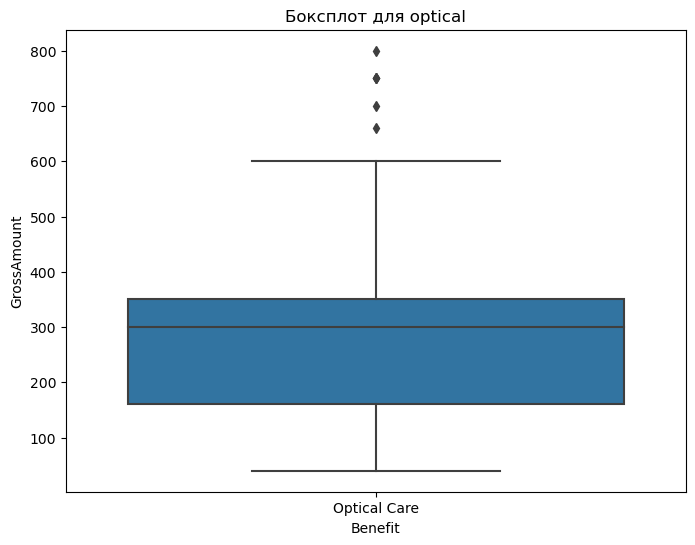

In [610]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Benefit', y='GrossAmount', data=optical)

plt.title('Боксплот для optical')
plt.show()

**На этом этапе почистила "выбросы" - делала это по ServiceName, логику описала выше. Более качественно это можно сделать, если будет разметка для каждого бенефита по кейсам. Также можно было бы делать чистку на уровне диагнозов в будущем:смотреть по хроническим/нехроническим заболеваниям. Сложности вызвала чистка Out-Patient и Maternity**



# Прогноз

**В первую очередь будем суммировать гросс по бенефитам**

In [623]:
claims_22['Benefit'].value_counts()

Benefit
Out-Patient     39617
Maternity        2734
In-Patient       2260
Dental Care      1995
Optical Care      544
Name: count, dtype: int64

In [904]:
claim = claims_22.copy()

In [629]:
claim_grouped = claim.groupby(['MemberID', 'PolicyID', 'ProviderID', 'Benefit'], as_index=False)['GrossAmount'].sum()
claim_grouped

,MemberID,PolicyID,ProviderID,Benefit,GrossAmount
0,61664,13876396-2022,445000,Out-Patient,4933.28
1,61664,13876396-2022,15332525,Out-Patient,320.56
2,61717,13876396-2022,12077,Out-Patient,8388.85
3,61975,13876396-2022,12077,Out-Patient,12509.91
4,61975,13876396-2022,141543,Out-Patient,362.65
...,...,...,...,...,...
4913,90751987,13876404-2022,12440,Dental Care,30.00
4914,90751987,13876404-2022,810979,Out-Patient,2835.90
4915,90751995,13876404-2022,810979,Out-Patient,130.85
4916,90752068,13876511-2022,810979,Out-Patient,1381.85


In [905]:
#Нулевые значения для каждого клиента, учтем их при расчете суммы
train_new = pd.merge(insured_22, claim_grouped, on='MemberID', how='left')
train_new = train_new.drop('PolicyID_y', axis=1)
train_new = train_new.rename(columns={'PolicyID_x': 'PolicyID'})

nulls = train_new[train_new['Benefit'].isnull() == True]
nulls['ClientID'].value_counts()

ClientID
2405838     103
67851323     93
2359244      91
2359246      55
421041       55
Name: count, dtype: int64

In [655]:
train = pd.merge(insured_22, claim_grouped, on='MemberID', how='left')
train = train.drop('PolicyID_x', axis=1)
train = train.rename(columns={'PolicyID_y': 'PolicyID'})
train

,MemberID,ProviderID,Benefit,GrossAmount,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,Age,Age category,policy duration
0,61664,445000,Out-Patient,4933.28,13876396-2022,2359246.0,Network-2,C,Group 2,Self,Male,55.0,18-65,365.0
1,61664,15332525,Out-Patient,320.56,13876396-2022,2359246.0,Network-2,C,Group 2,Self,Male,55.0,18-65,365.0
2,61717,12077,Out-Patient,8388.85,13876396-2022,2359246.0,Network-5,D,Group 1,Self,Male,53.0,18-65,365.0
3,61975,12077,Out-Patient,12509.91,13876396-2022,2359246.0,Network-5,D,Group 2,Self,Male,59.0,18-65,365.0
4,61975,141543,Out-Patient,362.65,13876396-2022,2359246.0,Network-5,D,Group 2,Self,Male,59.0,18-65,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4913,90751987,12440,Dental Care,30.00,13876404-2022,421041.0,Network-2,C,Group 2,Self,Male,40.0,18-65,364.0
4914,90751987,810979,Out-Patient,2835.90,13876404-2022,421041.0,Network-2,C,Group 2,Self,Male,40.0,18-65,364.0
4915,90751995,810979,Out-Patient,130.85,13876404-2022,421041.0,Network-5,D,Group 2,Self,Male,39.0,18-65,365.0
4916,90752068,810979,Out-Patient,1381.85,13876511-2022,2359244.0,Network-2,C,Group 2,Self,Male,40.0,18-65,365.0


In [657]:
#Пересчитаем гросс в зависимости от policy duration

train['Gross'] = round((train['GrossAmount'] * 365)/train['policy duration'], 2)
train

,MemberID,ProviderID,Benefit,GrossAmount,PolicyID,ClientID,MemberNetwork,Class,Nationality,Relation,Gender,Age,Age category,policy duration,Gross
0,61664,445000,Out-Patient,4933.28,13876396-2022,2359246.0,Network-2,C,Group 2,Self,Male,55.0,18-65,365.0,4933.28
1,61664,15332525,Out-Patient,320.56,13876396-2022,2359246.0,Network-2,C,Group 2,Self,Male,55.0,18-65,365.0,320.56
2,61717,12077,Out-Patient,8388.85,13876396-2022,2359246.0,Network-5,D,Group 1,Self,Male,53.0,18-65,365.0,8388.85
3,61975,12077,Out-Patient,12509.91,13876396-2022,2359246.0,Network-5,D,Group 2,Self,Male,59.0,18-65,365.0,12509.91
4,61975,141543,Out-Patient,362.65,13876396-2022,2359246.0,Network-5,D,Group 2,Self,Male,59.0,18-65,365.0,362.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4913,90751987,12440,Dental Care,30.00,13876404-2022,421041.0,Network-2,C,Group 2,Self,Male,40.0,18-65,364.0,30.08
4914,90751987,810979,Out-Patient,2835.90,13876404-2022,421041.0,Network-2,C,Group 2,Self,Male,40.0,18-65,364.0,2843.69
4915,90751995,810979,Out-Patient,130.85,13876404-2022,421041.0,Network-5,D,Group 2,Self,Male,39.0,18-65,365.0,130.85
4916,90752068,810979,Out-Patient,1381.85,13876511-2022,2359244.0,Network-2,C,Group 2,Self,Male,40.0,18-65,365.0,1381.85


**Разобьем по PolicyID и посмотрим подробнее внутри каждого 1) data_1 = 13915889, 2) data_2 = 13876511 3)data_3 = 13876404 4) data_4 = 13876396 5)data_5 = 13877014**

In [661]:
train['PolicyID'].value_counts()

PolicyID
13915889-2022    1247
13876511-2022    1172
13876404-2022     928
13876396-2022     867
13877014-2022     617
Name: count, dtype: int64

In [701]:
train['ClientID'].value_counts()

ClientID
67851323.0    1247
2359244.0     1172
421041.0       928
2359246.0      867
2405838.0      617
Name: count, dtype: int64

**Попробуем два метода: прогнозирование средним и прогнозирование медианой. Для того, чтобы прогнозировать средним нам не нужно углубляться в данные, мы будем суммировать гросс и пересчитывать его на 23 год. В случае с прогнозированием медианой лучше углубиться до определенного уровня и относительно него считать. Попробуем два метода и сравним результаты**

In [863]:
data_1 = train[train['PolicyID'] == '13915889-2022']
data_2 = train[train['PolicyID'] == '13876511-2022']
data_3 = train[train['PolicyID'] == '13876404-2022']
data_4 = train[train['PolicyID'] == '13876396-2022']
data_5 = train[train['PolicyID'] == '13877014-2022']

In [903]:
#Сумма выплат за 22 год для каждого ClientID
data_1_r = data_1.groupby(['PolicyID', 'ClientID'], as_index=False)['Gross'].sum()
data_2_r = data_2.groupby(['PolicyID', 'ClientID'], as_index=False)['Gross'].sum()
data_3_r = data_3.groupby(['PolicyID', 'ClientID'], as_index=False)['Gross'].sum()
data_4_r = data_4.groupby(['PolicyID', 'ClientID'], as_index=False)['Gross'].sum()
data_5_r = data_5.groupby(['PolicyID', 'ClientID'], as_index=False)['Gross'].sum()
sum_1 = data_1_r['Gross'].iloc[0]
sum_2 = data_2_r['Gross'].iloc[0] 
sum_3 = data_3_r['Gross'].iloc[0]
sum_4 = data_4_r['Gross'].iloc[0]
sum_5 = data_5_r['Gross'].iloc[0]
print('Сумма выплат в 22 году для ClientID 67851323 {:.2f}'.format(sum_1)) 
print(f'Сумма выплат в 22 году для ClientID 2359244 {sum_2}') 
print('Сумма выплат в 22 году для ClientID 421041 {:.2f}'.format(sum_3)) 
print(f'Сумма выплат в 22 году для ClientID 2359246 {sum_4}') 
print(f'Сумма выплат в 22 году для ClientID 2405838 {sum_5}') 

Сумма выплат в 22 году для ClientID 67851323 1819667.71
Сумма выплат в 22 году для ClientID 2359244 2194589.43
Сумма выплат в 22 году для ClientID 421041 1702600.11
Сумма выплат в 22 году для ClientID 2359246 1751921.21
Сумма выплат в 22 году для ClientID 2405838 636614.96


**Сумма считается следующим образом: (сумма гросс * кол-во клиентов в 23 году)/кол-во клиентов в 22 году + не сходившие клиенты(у которых гросс 0)**

In [855]:
#За 23 у нас для этого клиента теперь 582 memberID
pred_data_1 = insured_23[insured_23['ClientID'] == 67851323]
sum_data_1 = ((data_1_r['Gross'] * 582/(529+93))).iloc[0]
print('Сумма выплат в 23 году для ClientID 67851323 средним: {:.2f}'.format(sum_data_1))

pred_data_2 = insured_23[insured_23['ClientID'] == 2359244]
sum_data_2 = ((data_2_r['Gross'] * 245/(520+91))).iloc[0]
print('Сумма выплат в 23 году для ClientID 2359244 средним: {:.2f}'.format(sum_data_2))

pred_data_3 = insured_23[insured_23['ClientID'] == 421041]
sum_data_3 = ((data_3_r['Gross'] * 361)/(383+55)).iloc[0]
print('Сумма выплат в 23 году для ClientID 421041 средним: {:.2f}'.format(sum_data_3))

pred_data_4 = insured_23[insured_23['ClientID'] == 2359246]
sum_data_4 = ((data_4_r['Gross'] * 308)/(334+55)).iloc[0]
print('Сумма выплат в 23 году для ClientID 2359246 средним: {:.2f}'.format(sum_data_4))

pred_data_5 = insured_23[insured_23['ClientID'] == 2405838]
sum_data_5 = ((data_5_r['Gross'] * 350)/(352+103)).iloc[0]
print('Сумма выплат в 23 году для ClientID 2405838 средним: {:.2f}'.format(sum_data_5))

Сумма выплат в 23 году для ClientID 67851323 средним: 1702647.28
Сумма выплат в 23 году для ClientID 2359244 средним: 879990.85
Сумма выплат в 23 году для ClientID 421041 средним: 1403284.57
Сумма выплат в 23 году для ClientID 2359246 средним: 1387125.28
Сумма выплат в 23 году для ClientID 2405838 средним: 489703.82


In [704]:
insured_23['ClientID'].value_counts()

ClientID
67851323    582
421041      361
2405838     350
2359246     308
2359244     245
Name: count, dtype: int64

In [789]:
insured_22['ClientID'].value_counts()

ClientID
67851323    529
2359244     520
421041      383
2405838     352
2359246     334
Name: count, dtype: int64

**Теперь попробуем прогнозировать медианой. Для этого сделаем разрезы и спустившись до определенного уровня возьмем медиану гросса. Далее посчитав эти значения мы поднимемся обратно и посчитаем сумму**

In [856]:
data_1_level_1 = data_1.groupby(['Benefit', 'Gender', 'Nationality', 'Age category', 'Class'], as_index=False)['Gross'].median()

In [738]:
#Нашлись случаи, где бенефит maternity наблюдается у мужского пола - я решила такое почистить

data_1_level_1[data_1_level_1['Benefit'] == 'Maternity']

,Benefit,Gender,Nationality,Age category,Class,Gross
51,Maternity,Female,Group 2,18-65,A,42.00
52,Maternity,Female,Group 2,18-65,C,405.00
53,Maternity,Female,Group 3,18-65,A,400.50
54,Maternity,Female,Group 3,18-65,B,4957.20
55,Maternity,Female,Saudi,18-65,A,332.30
56,Maternity,Female,Saudi,18-65,B,643.06
57,Maternity,Male,Group 3,0-17,B,3374.01


In [741]:
train = train[~((train['Benefit'] == 'Maternity') & (train['Gender'] == 'Male'))]

In [860]:
#Теперь мы поднимаемся на уровень бенефитов

data_1_level_1_1 = data_1_level_1.groupby(['Benefit'], as_index=False)['Gross'].mean()
count_ben = data_1[['MemberID', 'Benefit']].drop_duplicates()

#Хочется посчитать долю людей на каждый бенефит и исходя из этого мы сразу будем делать пересчет на 23 год
val_out_pat_1 = (len(count_ben[count_ben['Benefit'] == 'Out-Patient']))/(count_ben['MemberID'].nunique())
val_in_pat_1 = (len(count_ben[count_ben['Benefit'] == 'In-Patient']))/(count_ben['MemberID'].nunique())
val_mat_1 = (len(count_ben[count_ben['Benefit'] == 'Maternity']))/(count_ben['MemberID'].nunique())
val_opt_car_1 = (len(count_ben[count_ben['Benefit'] == 'Optical Care']))/(count_ben['MemberID'].nunique())
val_dent_car_1 = (len(count_ben[count_ben['Benefit'] == 'Dental Care']))/(count_ben['MemberID'].nunique())

member_1 = 582
data_1_level_1_1['coeff'] = pd.DataFrame([val_dent_car_1, val_in_pat_1, val_mat_1, val_opt_car_1, val_out_pat_1])
data_1_res_2 = sum(data_1_level_1_1['coeff']* data_1_level_1_1['Gross']*member_1)
print(f'Сумма выплат в 23 году для ClientID 67851323 медианой: {data_1_res_2}')

Сумма выплат в 23 году для ClientID 67851323 медианой: 1395382.4938573812


In [865]:
#Тут пыталась два раза взять медиану, но дорогие кейсы никак не учитываются, что тоже неправильно
data = data_1_level_1.copy()
data = data_1_level_1.groupby(['Benefit'], as_index= False)['Gross'].median()

data['coeff'] = pd.DataFrame([val_dent_car_1, val_in_pat_1, val_mat_1, val_opt_car_1, val_out_pat_1])
data_2_2 = sum(data['coeff']* data['Gross']*member_1)
data_2_2 

701701.8154816513

In [906]:
#Универсальная функция, чтобы прогнать для всех клиентов

def calculate_payouts(data, member_count):
    data_level_1 = data.groupby(
        ['Benefit', 'Gender', 'Nationality', 'Age category', 'Class'], 
        as_index=False
    )['Gross'].median()

    count_ben = data[['MemberID', 'Benefit']].drop_duplicates()

    data_level_1_1 = data_level_1.groupby(['Benefit'], as_index=False)['Gross'].mean()

    val_out_pat = len(count_ben[count_ben['Benefit'] == 'Out-Patient']) / count_ben['MemberID'].nunique()
    val_in_pat = len(count_ben[count_ben['Benefit'] == 'In-Patient']) / count_ben['MemberID'].nunique()
    val_mat = len(count_ben[count_ben['Benefit'] == 'Maternity']) / count_ben['MemberID'].nunique()
    val_opt_car = len(count_ben[count_ben['Benefit'] == 'Optical Care']) / count_ben['MemberID'].nunique()
    val_dent_car = len(count_ben[count_ben['Benefit'] == 'Dental Care']) / count_ben['MemberID'].nunique()
    
    data_level_1_1['coeff'] = pd.DataFrame([
        val_dent_car, val_in_pat, val_mat, val_opt_car, val_out_pat
    ])

    result = sum(data_level_1_1['coeff'] * data_level_1_1['Gross'] * member_count)

    return result

#member_i - кол-во memberID у клиента(компании) в 23 году
member_1 = 582
member_2 = 245
member_3 = 361
member_4 = 308
member_5 = 350
result_1 = calculate_payouts(data_1, member_1)
result_2 = calculate_payouts(data_2, member_2)
result_3 = calculate_payouts(data_3, member_3)
result_4 = calculate_payouts(data_4, member_4)
result_5 = calculate_payouts(data_5, member_5)

print(f'Сумма выплат в 23 году для ClientID 67851323 медианой: {result_1}')
print(f'Сумма выплат в 23 году для ClientID 2359244 медианой: {result_2}')
print(f'Сумма выплат в 23 году для ClientID 421041 медианой: {result_3}')
print(f'Сумма выплат в 23 году для ClientID 2359246 медианой: {result_4}')
print(f'Сумма выплат в 23 году для ClientID 2405838 медианой: {result_5}')

Сумма выплат в 23 году для ClientID 67851323 медианой: 1395382.4938573812
Сумма выплат в 23 году для ClientID 2359244 медианой: 588703.9641119107
Сумма выплат в 23 году для ClientID 421041 медианой: 1108265.7451727549
Сумма выплат в 23 году для ClientID 2359246 медианой: 617623.8870493891
Сумма выплат в 23 году для ClientID 2405838 медианой: 588496.4985746909


**Вывод: в данной работе я делала прогноз средним и медианой. Результаты относительно сопоставимы, как и ожидалось, прогнозирование медианой дало "заниженную" сумму выплат, относительно прогнозирования средним. Для более корректного прогноза не хватает данных по бенефитам для insured23. Не учитывался ProviderID, в дальнейшем можно его учесть. Также можно составить более корректный прогноз для бенефита maternity (описывала идею при рассмотрении бенефита). Интересно было бы решить задачу с применением алгоритмов ML.**